In [1]:
import os
import numpy as np

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'hmog_public_dataset/'

In [2]:
import pickle

test_file = open('hmog_dataset', 'rb')
session_hmog_matrices = pickle.load(test_file)
test_file.close()

In [3]:
# We need to exclude subjects who used landscape orientation
landscape_subjects = ['856302', '751131', '220962', '186676', '980953', '201848', '675397']
for l_s in landscape_subjects:
    del session_hmog_matrices[l_s]

subjects_list = list(session_hmog_matrices.keys())
print(f'len: {len(subjects_list)}\n\n{subjects_list}')

len: 92

['342329', '240168', '472761', '352716', '219303', '431312', '556357', '717868', '862649', '990622', '937904', '745224', '841866', '799296', '621276', '827212', '876011', '986737', '171538', '973891', '865881', '248252', '218719', '389015', '918136', '803262', '261313', '207969', '892687', '257279', '785873', '879155', '966655', '326223', '264325', '256487', '553321', '923862', '526319', '733568', '579284', '277905', '777078', '776328', '893255', '100669', '278135', '501973', '405035', '395129', '710707', '578526', '998757', '897652', '737973', '984799', '525584', '913228', '720193', '336172', '785899', '527796', '594887', '588087', '698266', '622852', '815316', '180679', '151985', '962159', '872895', '396697', '538363', '863985', '657486', '856401', '561993', '540641', '893198', '808022', '366286', '663153', '763813', '368258', '539502', '693572', '489146', '771782', '796581', '398248', '865501', '554303']


# Feature Selection

Let's perform feature selection using Fisher score

In [ ]:
# import numpy as np

# from sklearn.svm import OneClassSVM

# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.decomposition import PCA

# # Assuming your dataset is stored in X_train numpy array
# # X_train should have shape (n_samples, n_features)

# # Step 1: Feature selection using Fisher score
# # Select the top k features based on Fisher score
# k_best_features = 10  # Adjust this value as needed

# true_pos_rate_sum = 0
# count = len(subjects_list)

# for i in range(len(subjects_list)):
#     subject = subjects_list[i]
#     std_deviations, session_hmog_vector = HmogHelper.calc_std_and_scale(session_hmog_matrices[subject][0])

#     selector = SelectKBest(score_func=f_classif, k=k_best_features)
#     X_train = selector.fit_transform(session_hmog_vector, np.ones(len(session_hmog_vector)))  # All instances are considered as positive class

#     # PCA
#     n_components = 5  # Number of principal components to keep
#     pca = PCA(n_components=n_components)
#     X_train_pca = pca.fit_transform(X_train)

#     svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(X_train_pca)
#     true_pos_rate_sum += HmogHelper.test_hmog(X_train_pca, 1, svm)

# print(f'Same session whole dataset average true positive ratio: {true_pos_rate_sum / count}')

# Windowed Tests

## Single subject, same-session tests

In [16]:
WINDOW_SIZE = 40000  # ms
WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

In [11]:
from sklearn.svm import OneClassSVM

# Windowed tests

for window_size in WINDOW_SIZES:
    true_pos_rate_sum = 0

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        session_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        # We scale all columns except for the 0th one (it's a timestamp)
        std_deviations, session_hmog_vector = HmogHelper.calc_std_and_scale(session_hmog_vector)
        session_hmog_vector_no_timestamp = np.delete(session_hmog_vector, 0, axis=1)

        # print(session_hmog_vector.shape)

        svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(session_hmog_vector_no_timestamp)
        true_pos_rate_sum += HmogHelper.test_hmog_windowed(session_hmog_vector, t_window=window_size, correct_key=1, model=svm)

    total_accuracy_windowed = true_pos_rate_sum / len(subjects_list)

    print(f'window size: {window_size / 1000}s.\nAccuracy windowed same-session tests: {total_accuracy_windowed}')
    

window size: 20.0s.
Accuracy windowed same-session tests: 0.9993125876063644
window size: 40.0s.
Accuracy windowed same-session tests: 1.0
window size: 60.0s.
Accuracy windowed same-session tests: 0.9995819397993312
window size: 80.0s.
Accuracy windowed same-session tests: 1.0
window size: 100.0s.
Accuracy windowed same-session tests: 1.0
window size: 120.0s.
Accuracy windowed same-session tests: 1.0
window size: 140.0s.
Accuracy windowed same-session tests: 1.0


## Single subject, different sessions tests

In [5]:
from sklearn.svm import OneClassSVM

for window_size in WINDOW_SIZES:

    true_pos_ratio_sum = 0
    count = len(subjects_list)

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        session_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        std_deviations, session_hmog_vector = HmogHelper.calc_std_and_scale(session_hmog_vector)
        session_hmog_vector_no_timestamp = np.delete(session_hmog_vector, 0, axis=1)

        test_hmog_vector = np.vstack((session_hmog_matrices[subject][2], session_hmog_matrices[subject][3]))
        test_hmog_vector = HmogHelper.scale_by(test_hmog_vector, std_deviations)

        if test_hmog_vector.shape[0] == 0:
            count -= 1
            continue

        svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(session_hmog_vector_no_timestamp)
        true_pos_ratio_sum += HmogHelper.test_hmog_windowed(test_hmog_vector, t_window=window_size, correct_key=1, model=svm)

    print(f'window size: {window_size / 1000}s.\nOut-of-session whole dataset average true positive ratio: {true_pos_ratio_sum / count}')

NameError: name 'OneClassSVM' is not defined

## Different subjects tests

In [12]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

other_subjects_windowed_results = {}

for window_size in WINDOW_SIZES:
    true_neg_rate_sum = 0

    eer_list = []

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        train_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
        train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

        # We use sessions belonging to the same subject for tests as well (but the sessions are different)
        test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][2], session_hmog_matrices[subject][3]))
        test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)

        test_hmog_vector_negative = None
        
        svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_hmog_vector_no_timestamp)

        other_subjects = subjects_list.copy()
        del other_subjects[i]

        for another_subject in other_subjects:
            test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][2], session_hmog_matrices[another_subject][3]))

            if test_hmog_vector_new.shape[0] == 0:
                continue

            if test_hmog_vector_negative is None:
                test_hmog_vector_negative = test_hmog_vector_new
            else:
                test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

        # Now we need to scale the whole vector
        test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)

        predictions_self = HmogHelper.test_hmog_windowed(test_hmog_vector_positive, t_window=window_size, model=svm)
        y_true = [1] * len(predictions_self)

        predictions_others = HmogHelper.test_hmog_windowed(test_hmog_vector_negative, t_window=window_size, model=svm)
        y_true += ([-1] * len(predictions_others))

        scores = predictions_self + predictions_others

        fpr, tpr, thresholds = roc_curve(y_true, scores)

        # Find the threshold where FPR equals FNR
        eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
        eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
        
        # Append EER to the list
        eer_list.append(eer)
    
    population_eer = np.mean(eer_list)
    other_subjects_windowed_results[window_size] = population_eer

    print(f'Window size: {window_size / 1000}s\nPopulation EER: {other_subjects_windowed_results[window_size]}')

Window size: 20.0s
Population EER: 0.1529992278868255
Window size: 40.0s
Population EER: 0.14460728159284708
Window size: 60.0s
Population EER: 0.1435655901751336
Window size: 80.0s
Population EER: 0.13708822997182254
Window size: 100.0s
Population EER: 0.12702076277349977
Window size: 120.0s
Population EER: 0.1406794888583894
Window size: 140.0s
Population EER: 0.13551386690688752


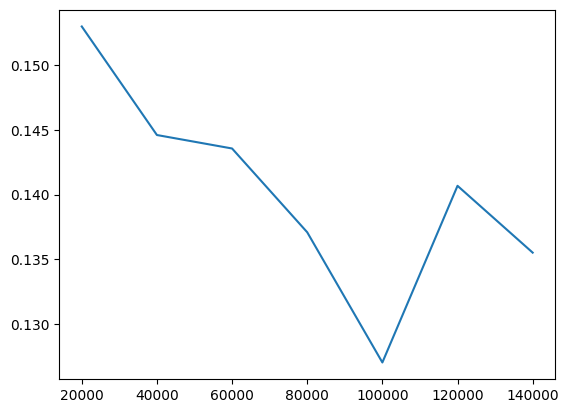

In [13]:
import matplotlib.pyplot as plt

plt.plot(WINDOW_SIZES, list(other_subjects_windowed_results.values()))

# Scaled Euclidean

Let's perform the same tests, but with a scaled Euclidean classifier instead of a One class SVM

In [5]:
import numpy as np
import numpy.linalg as LA
from sklearn.metrics import roc_curve

from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

SE_WINDOW_PERRs = {}

for window_size in WINDOW_SIZES:
    eer_list = []

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        train_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
        train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

        # We use sessions belonging to the same subject for tests as well (but the sessions are different)
        test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][2], session_hmog_matrices[subject][3]))
        test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)

        test_hmog_vector_negative = None
        
        se_model = models.SEClassifier()
        se_model.fit(train_hmog_vector_no_timestamp)

        other_subjects = subjects_list.copy()
        del other_subjects[i]

        for another_subject in other_subjects:
            test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][2], session_hmog_matrices[another_subject][3]))

            if test_hmog_vector_new.shape[0] == 0:
                continue

            if test_hmog_vector_negative is None:
                test_hmog_vector_negative = test_hmog_vector_new
            else:
                test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

        # Now we need to scale the whole vector
        test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)

        predictions_self = HmogHelper.test_hmog_windowed(test_hmog_vector_positive, t_window=window_size, model=se_model)
        y_true = [0] * len(predictions_self)

        predictions_others = HmogHelper.test_hmog_windowed(test_hmog_vector_negative, t_window=window_size, model=se_model)
        y_true += ([1] * len(predictions_others))

        scores = predictions_self + predictions_others

        fpr, tpr, thresholds = roc_curve(y_true, scores)

        # Find the threshold where FPR equals FNR
        eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
        eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
        
        # Append EER to the list
        eer_list.append(eer)
    
    population_eer = np.mean(eer_list)
    SE_WINDOW_PERRs[window_size] = population_eer

    print(f'Window size: {window_size / 1000}s\nPopulation EER: {SE_WINDOW_PERRs[window_size]}')

Window size: 20.0s
Population EER: 0.16289019411261532
Window size: 40.0s
Population EER: 0.15649402470651072
Window size: 60.0s
Population EER: 0.13823614504029005
Window size: 80.0s
Population EER: 0.13271698574883556
Window size: 100.0s
Population EER: 0.13049591444977865
Window size: 120.0s
Population EER: 0.13546037919695883
Window size: 140.0s
Population EER: 0.135487345744236


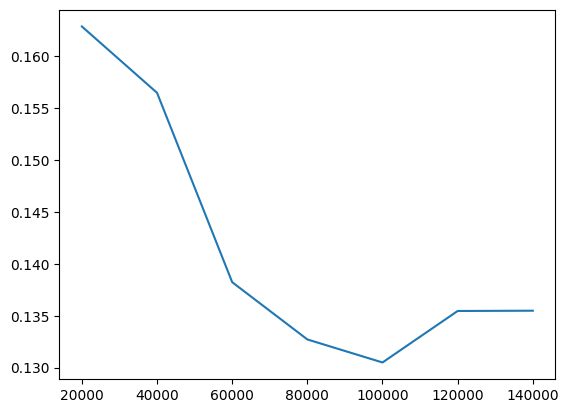

In [6]:
import matplotlib.pyplot as plt

plt.plot(WINDOW_SIZES, list(SE_WINDOW_PERRs.values()))

## Scaled Manhattan

In [4]:
import numpy as np
import numpy.linalg as LA
from sklearn.metrics import roc_curve

from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

SM_WINDOW_PEERs = {}

for window_size in WINDOW_SIZES:
    eer_list = []

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        train_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
        train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

        # We use sessions belonging to the same subject for tests as well (but the sessions are different)
        test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][2], session_hmog_matrices[subject][3]))
        test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)

        test_hmog_vector_negative = None
        
        se_model = models.SMClassifier()
        se_model.fit(train_hmog_vector_no_timestamp)

        other_subjects = subjects_list.copy()
        del other_subjects[i]

        for another_subject in other_subjects:
            test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][2], session_hmog_matrices[another_subject][3]))

            if test_hmog_vector_new.shape[0] == 0:
                continue

            if test_hmog_vector_negative is None:
                test_hmog_vector_negative = test_hmog_vector_new
            else:
                test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

        # Now we need to scale the whole vector
        test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)

        predictions_self = HmogHelper.test_hmog_windowed(test_hmog_vector_positive, t_window=window_size, model=se_model)
        y_true = [0] * len(predictions_self)

        predictions_others = HmogHelper.test_hmog_windowed(test_hmog_vector_negative, t_window=window_size, model=se_model)
        y_true += ([1] * len(predictions_others))

        scores = predictions_self + predictions_others

        fpr, tpr, thresholds = roc_curve(y_true, scores)

        # Find the threshold where FPR equals FNR
        eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
        eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
        
        # Append EER to the list
        eer_list.append(eer)
    
    population_eer = np.mean(eer_list)
    SM_WINDOW_PEERs[window_size] = population_eer

    print(f'Window size: {window_size / 1000}s\nPopulation EER: {SM_WINDOW_PEERs[window_size]}')

Window size: 20.0s
Population EER: 0.15035392149542434
Window size: 40.0s
Population EER: 0.12018275275090154
Window size: 60.0s
Population EER: 0.11223300931810712
Window size: 80.0s
Population EER: 0.10529697181317828
Window size: 100.0s
Population EER: 0.10309369983851503
Window size: 120.0s
Population EER: 0.10441135233119506
Window size: 140.0s
Population EER: 0.10393745426387771


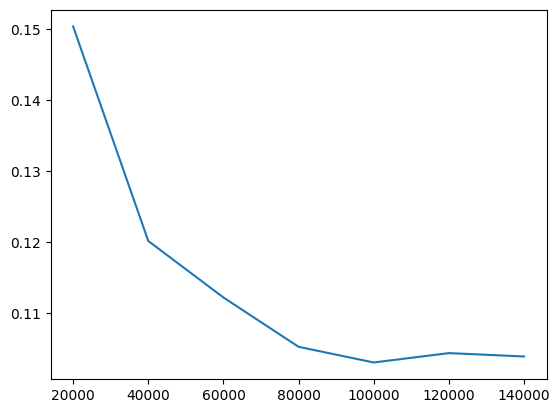

In [6]:
import matplotlib.pyplot as plt

plt.plot(WINDOW_SIZES, list(SM_WINDOW_PEERs.values()))

# Visualisations

## Tables
Let's put all results into a table (window_size vs. sm/se/oneclasssvm)

In [ ]:
from tabulate import tabulate

